# Boxplots

## Script setup

In [2]:
# Third-party and standard modules
from typing import Dict, Hashable
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import pytz
import datetime
from importlib import reload
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
# User-defined modules.
# The reload() function is needed to update modules after
# changes are made to their files.
from modules import dataframe_manip as dfm
from modules import misc, schemas, College1AcPtTimeSeries
# The reload() function is needed to update modules after
# changes are made to their files.
dfm = reload(dfm)
misc = reload(misc)
schemas = reload(schemas)
College1AcPtTimeSeries = reload(College1AcPtTimeSeries)

In [3]:
schema: schemas.AcPtTimeSeries =\
    College1AcPtTimeSeries.College1AcPtTimeSeries

## Script parameters

The following values are this script's parameters.

1. filepath - path to csv file you would like to analyze
2. buildings - the list of buildings you would like to analyze
3. start_date and end_date - can be "None" if you wish to analyze the whole dataset
3. boxplot_hourly_average - set to true or false, depending if you want to display the total, weekday, and weekend graphs
4. holiday_analysis - set to true or false, if you would like to see the average occupancy of the holidays in the given date ranges

In [4]:
#filepath = './cisco_wifi_data_until_20190513.csv'
filepath = './wifi_data_until_20190204.csv'
timezone = pytz.timezone('US/Pacific')
'''buildings = ['SCC', 'HAHN', 'CROOKSHANK', 'THATHCHER', 'CLARK',
                'CARNEGIE', 'MASON', 'PEARSON', 'ALEXANDER', 'ITB']
'''
buildings = ['ALEXANDER']

start_date = '2018-10-11' #None
end_date = '2018-10-21' #None


boxplot_hourly_average = True
holiday_analysis = True

## Data Processing

In [6]:
# A time-series dataframe holding occupancy counts
# for many access points (columns).
occ: pd.DataFrame = dfm.csv_to_timeseries_df(
    filepath=filepath, timezone=timezone
)

In [7]:
# Convert to df values to strings in order to compare to given range
csv_start_date = occ.index[0].strftime('%Y-%m-%d')
csv_end_date = occ.index[-1].strftime('%Y-%m-%d')

In [8]:
# Date range error checking
if end_date < start_date:
    print("end_date is before start_date")
    exit()
    
if start_date < csv_start_date :
    print("Desired start_date is before the first day of the csv, please fix this to continue")
    exit()
    
if end_date > csv_end_date:
    print("Desired end_date filter is after the last day of the csv, please fix this to continue")
    exit()


In [9]:
# Apply date range filter on the dataframe
if start_date is not None: 
    if end_date is None:
        occ = occ.loc[start_date:]
    else:
        occ = occ.loc[start_date:end_date]
else:
    if end_date is not None:
        occ = occ.loc[:end_date]

In [10]:
# Eliminate columns for access points not in the buildings we want.
occ = occ.drop(columns=list(filter(
    # add to drop-list if NOT in the buildings we want.
    lambda col: schema.col_to_building(col, safe=True) not in buildings,
    occ.columns.to_list()
)))
'''
# We must assume that intervening na-values are 0's.
occ = dfm.fill_intervening_nas(
    occ, inplace=True, fill_val=0
)
'''

"\n# We must assume that intervening na-values are 0's.\nocc = dfm.fill_intervening_nas(\n    occ, inplace=True, fill_val=0\n)\n"

In [11]:
occ_bybuild = occ.groupby(
    by=schema.col_to_building, axis=1
)

In [12]:
print('buildings not found: {}'.format(set(buildings) - set(occ_bybuild.groups.keys())))

# We can only work with the buildings we found.
buildings = list(occ_bybuild.groups.keys())

buildings not found: set()


## Boxplots

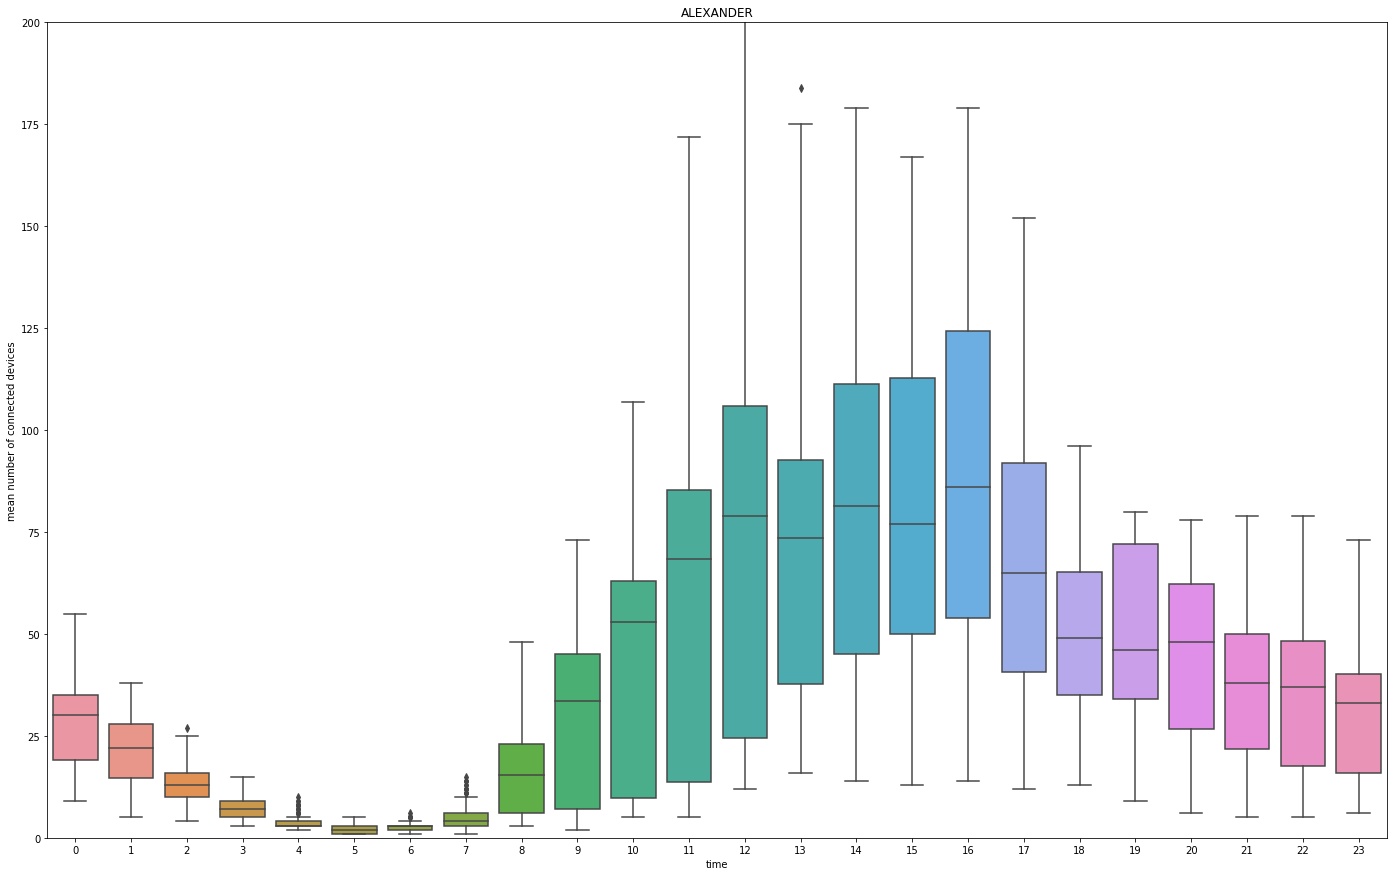

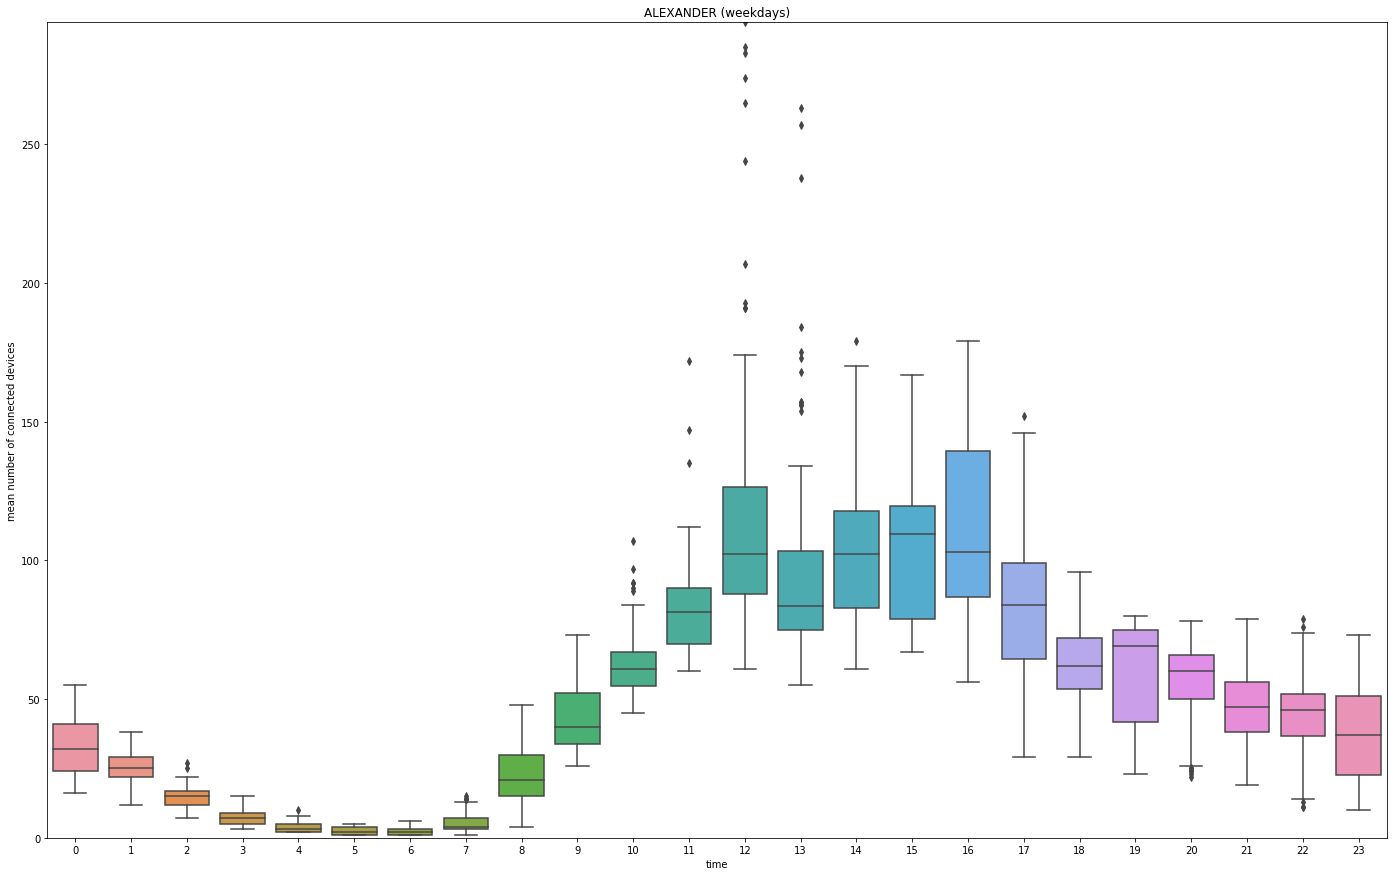

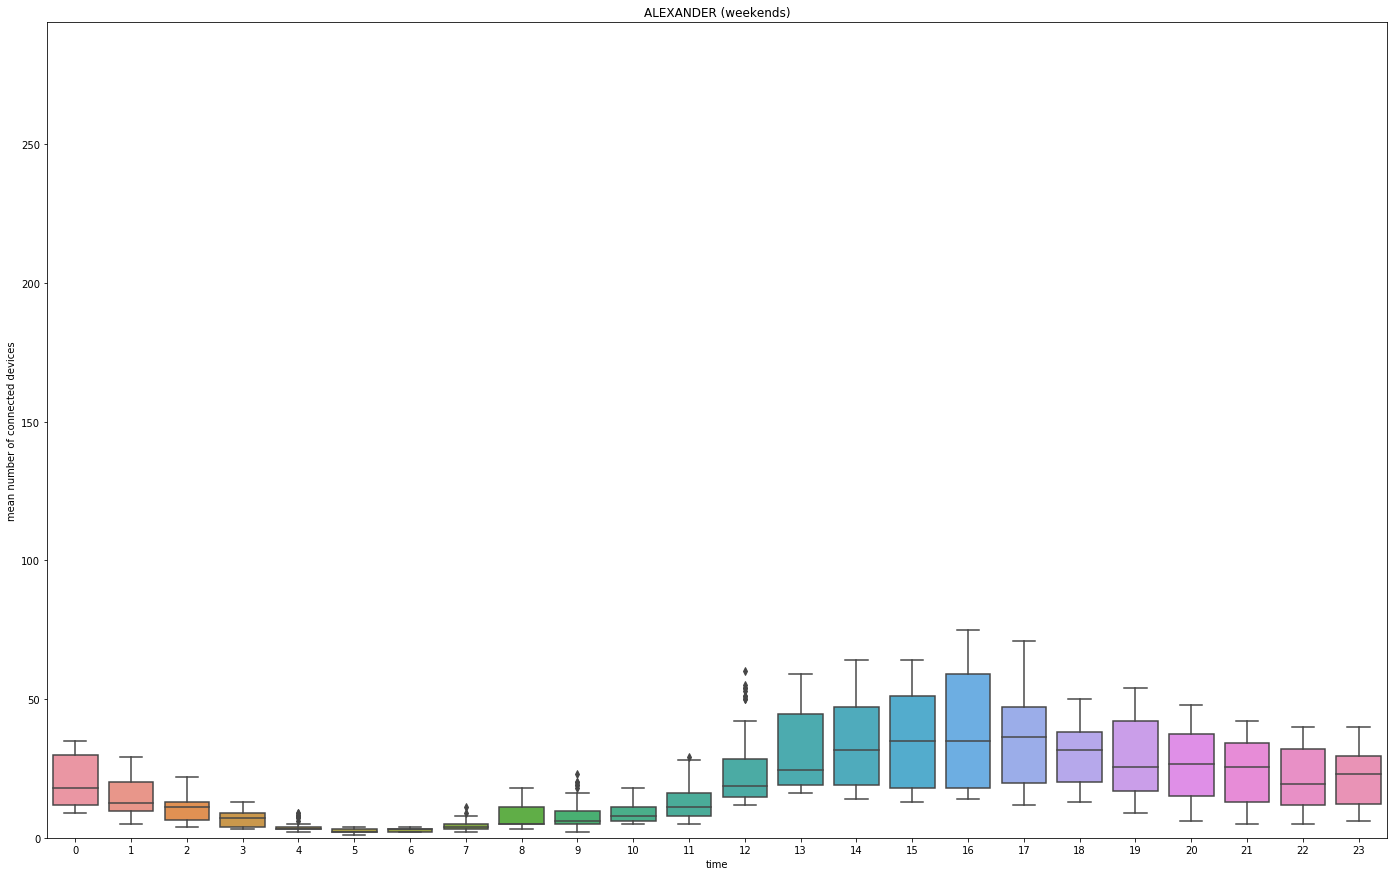

In [13]:
if(boxplot_hourly_average == True):
    means_by_building: Dict[Hashable, pd.DataFrame] = {}
    maxmean = float('-inf')
    for build in buildings:
        means_by_building[build] = dfm.row_means(occ_bybuild.get_group(build))
        newmax = means_by_building[build].max()
        newmin = means_by_building[build].min()
        maxmean = newmax if newmax > maxmean else maxmean
    #print(maxmean)

    for build in buildings:
        mean_occ: pd.DataFrame = dfm.row_means(occ_bybuild.get_group(build))

        # Prints graph for average occupancy per hour of each each building 
        fig, ax = plt.subplots(figsize=(24, 15))
        ax.set_title(build)
        ax.set_xlabel('hour of the day')
        ax.set_ylabel('mean number of connected devices')
        ax.set_ylim(0, 200)

        seaborn.boxplot(
            # The hours (a number [0,23]) for each row.
            x=mean_occ.index.hour,
            # The total occupancy at that hour.
            y=mean_occ,
            ax=ax
        )

        # Prints graph of weekday average occupancy per hour of each each building 
        try:
            fig, ax = plt.subplots(figsize=(24, 15))
            ax.set_title(build + ' (weekdays)')
            ax.set_xlabel('hour of the day')
            ax.set_ylabel('mean number of connected devices')
            ax.set_ylim(0, maxmean)

            wkdays = mean_occ.loc[mean_occ.index.dayofweek<5].copy()
        
            seaborn.boxplot(
                # The hours (a number [0,23]) for each row.
                x=wkdays.index.hour,
                # The total occupancy at that hour.
                y=wkdays,
                ax=ax
            )
        except Exception as e:
            print("No weekdays dates available in data set. Error: {}".format(e))
            raise e
        
        
        # Prints graph of weekend average occupancy per hour of each each building 
        try:
            fig, ax = plt.subplots(figsize=(24, 15))
            ax.set_title(build + ' (weekends)')
            ax.set_xlabel('hour of the day')
            ax.set_ylabel('mean number of connected devices')
            ax.set_ylim(0, maxmean)

            wkends = mean_occ.loc[mean_occ.index.dayofweek>=5].copy()


            seaborn.boxplot(
                # The hours (a number [0,23]) for each row.
                x=wkends.index.hour,
                # The total occupancy at that hour.
                y=wkends,
                ax=ax
            )
        except Exception as e:
            print("No weekend dates available in data set. Error: {}".format(e))
            raise e
            
        
        # Saves the graphs as .png
        #fig.savefig('./{}.png'.format(build))

## Holidays

In [14]:
if (holiday_analysis == True):
    
    # Get all US holidays between time range
    holi_caldr = calendar()
    holidays = holi_caldr.holidays(start = start_date, end = end_date)

    # Shows what holidays are going to be included in this data set analysis 
    display(holidays)
    
    # Convert to date time inorder to compare with our df index
    holiday_ts = pd.to_datetime(holidays)

    truncated_time = occ.index.normalize()
    occ['time_no_timezone'] = truncated_time.tz_localize(None)
    
    # Check if the date matches our list of holidays
    occ['isHoliday'] = occ['time_no_timezone'].isin(holiday_ts)

    display(occ)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

,POM-ALEXANDER133-AP205-12,POM-ALEXANDER-SR-AP205-5,POM-ALEXANDER-SE-AP275-1,POM-ALEXANDER235B-AP205-16,POM-ALEXANDER241-AP205-17,POM-ALEXANDER118-AP205-24,POM-ALEXANDER122A-AP205-23,POM-ALEXANDER101-AP205-10,POM-ALEXANDER134-AP205-2,POM-ALEXANDER204-AP205-17,...,POM-ALEXANDER244-AP205-13,POM-ALEXANDER139-AP205-3,POM-ALEXANDER208-AP205-8,POM-ALEXANDER215-AP205-15,POM-ALEXANDER1C09-AP205-2,POM-ALEXANDER224-AP205-3,POM-ALEXANDER217-AP205-20,POM-ALEXANDER251-AP205-13,time_no_timezone,isHoliday
time,,,,,,,,,,,,,,,,,,,,,
2018-10-11 00:00:14-07:00,NaN,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-11,False
2018-10-11 00:05:13-07:00,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-11,False
2018-10-11 00:10:20-07:00,NaN,NaN,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-11,False
2018-10-11 00:15:14-07:00,NaN,NaN,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-11,False
2018-10-11 00:20:10-07:00,NaN,NaN,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-11,False
2018-10-11 00:25:22-07:00,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-11,False
2018-10-11 00:30:14-07:00,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-11,False
2018-10-11 00:35:14-07:00,NaN,NaN,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-11,False
2018-10-11 00:40:25-07:00,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-11,False


-inf
No holidays in this data set. Error: min() arg is an empty sequence


ValueError: min() arg is an empty sequence

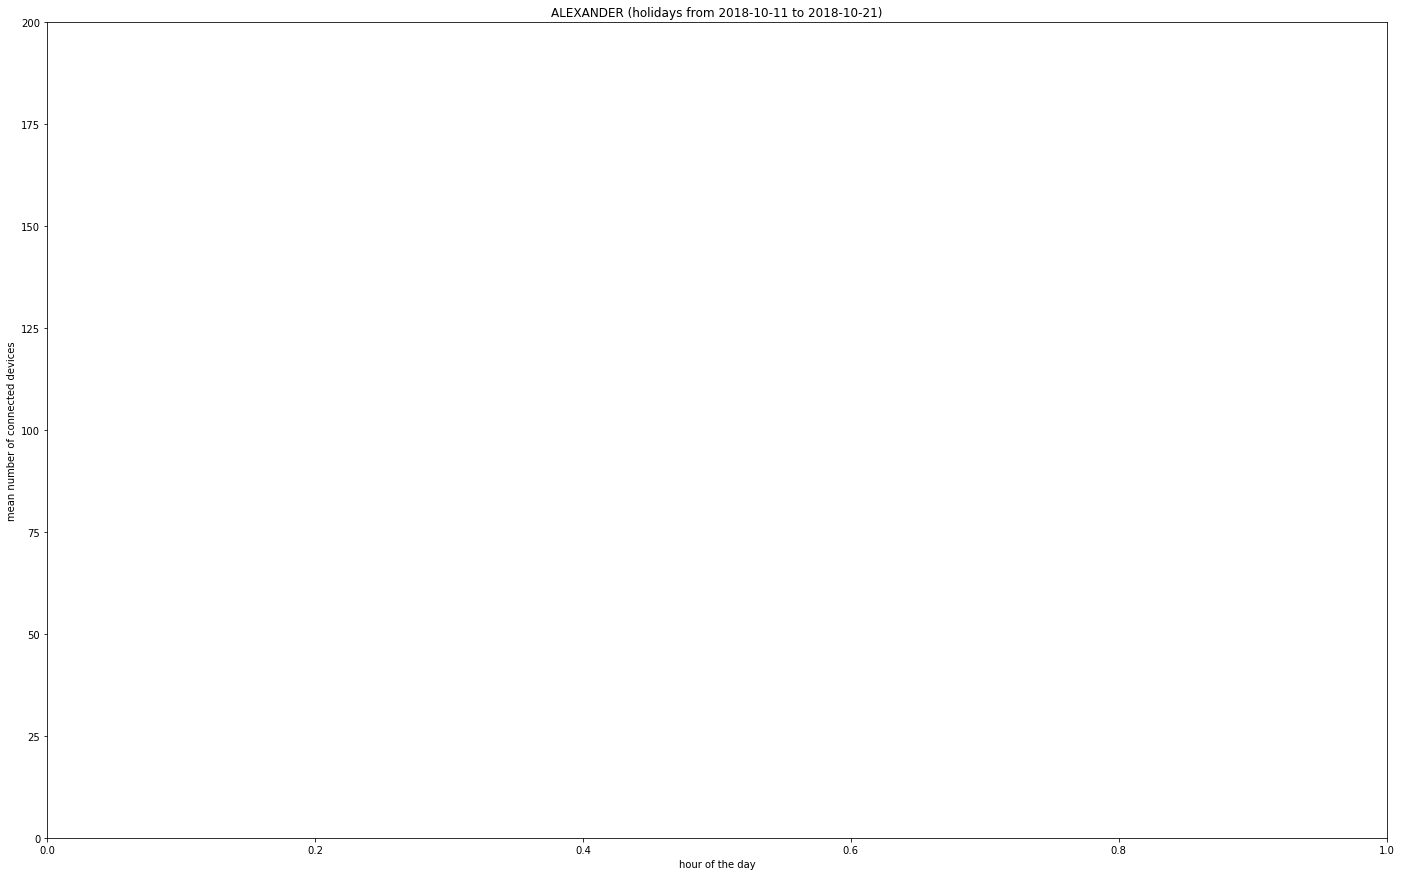

In [17]:
if (holiday_analysis == True):
    
    # Create a new df holiday_occ
    # If the date is a holiday, copy the data to holiday_occ
    holiday_occ = occ.loc[occ['isHoliday'] == True]
    #display(occ)
    holiday_occ = holiday_occ.drop(['time_no_timezone', 'isHoliday'], axis =1)
    occ_holiday_bybuild = holiday_occ.groupby(
        by=schema.col_to_building, axis=1
    )

    means_by_building: Dict[Hashable, pd.DataFrame] = {}
    maxmean = float('-inf')
    for build in buildings:
        means_by_building[build] = dfm.row_means(occ_holiday_bybuild.get_group(build))
        newmax = means_by_building[build].max()
        newmin = means_by_building[build].min()
        maxmean = newmax if newmax > maxmean else maxmean

    for build in buildings:
        
         # Prints graph of holiday average occupancy per hour of each each building 
        try:
            mean_occ_holiday: pd.DataFrame = dfm.row_means(occ_holiday_bybuild.get_group(build))

            fig, ax = plt.subplots(figsize=(24, 15))
            ax.set_title(build + ' (holidays from ' + start_date + ' to ' + end_date +')')
            ax.set_xlabel('hour of the day')
            ax.set_ylabel('mean number of connected devices')
            ax.set_ylim(0, 200)

            seaborn.boxplot(
                # The hours (a number [0,23]) for each row.
                x=mean_occ_holiday.index.hour,
                # The total occupancy at that hour.
                y=mean_occ_holiday,
                ax=ax
            )
        except Exception as e:
            print("No holidays in this data set. Error: {}".format(e))
            raise e
